##### Copyright 2018 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention



Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
tf.__version__

'2.3.0'

In [3]:
# PATH = "/content/drive/My Drive/img_caption/clean_data"

In [4]:
PATH= "/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic"

## Read annotation json file 

In [5]:
# # Read the json file
# with open(PATH + "/caption_tugu.json", 'r') as f:
#     annotations_tugu = json.load(f)

# # Read the json file
# with open(PATH + "/jeram.json", 'r') as f:
#     annotations_jeram = json.load(f)

# # Read the json file
# with open(PATH + "/malioboro_1.json", 'r') as f:
#     annotations_malioboro = json.load(f)

# # Read the json file
# with open(PATH + "/pendaki.json", 'r') as f:
#     annotations_pendaki = json.load(f)

# # Read the json file
# with open(PATH + "/wisata_jeep.json", 'r') as f:
#     annotations_wj = json.load(f)


In [6]:
# print(len(annotations_tugu))
# print(len(annotations_jeram))
# print(len(annotations_malioboro))
# print(len(annotations_pendaki))
# print(len(annotations_wj))

In [7]:
# annotations = annotations_tugu + annotations_jeram + annotations_malioboro + annotations_pendaki + annotations_wj

In [8]:
# with open('/content/drive/My Drive/img_caption/clean_data/all_caption.json', 'w') as fp:
#     json.dump(annotations, fp)

In [9]:
with open(PATH + "/all_caption.json", 'r') as f:
  annotations = json.load(f)

In [10]:
len(annotations)

502

In [11]:
annotations[-10:]

[{'caption': 'wisata Merapi Kaliadem Private Jeep Tour Yogyakarta',
  'image_id': 'bpxyq3gif29ueadrjsk4.jpeg'},
 {'caption': 'wisata Merapi Kaliadem Private Jeep Tour Yogyakarta',
  'image_id': 'wzp84130cv97ehfjod65.jpg'},
 {'caption': 'foto di atas mobil jeep keren',
  'image_id': 'oalhni36vc54x71ywdzm.jpg'},
 {'caption': 'wisata jeep gunung merapi sleman',
  'image_id': '10xw7yod4hm6ucqf3tik.jpg'},
 {'caption': 'foto di atas mobil jeep keren',
  'image_id': '2t5v3lbxsrzuckwhp4oi.jpg'},
 {'caption': 'wisata jeep gunung merapi sleman',
  'image_id': 'fno8gyi0q419dtphs7v2.jpg'},
 {'caption': 'wisata jeep gunung merapi sleman',
  'image_id': '8zy0to4ar1pscw6f5l9k.jpeg'},
 {'caption': 'serunya naik mobil jeep di medan batu',
  'image_id': '8au3feqcg5416z07owml.jpg'},
 {'caption': 'foto di atas mobil jeep keren',
  'image_id': 'mgof6y583zu0itv7cq2w.jpeg'},
 {'caption': 'foto di atas mobil jeep keren',
  'image_id': 'r73sufm4nh0gc9jy2klb.jpg'}]

In [12]:
# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_image_path = PATH + '/dataset_efficientNet/' + '{IMG}'.format(IMG=image_id)
# /content/drive/My Drive/img_caption/clean_data/img_gabung
    all_img_name_vector.append(full_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

num_examples = 480
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [13]:
train_captions[:10]

['<start> suasana yang Hanya Bisa Dirasakan Saat Mendaki gunung <end>',
 '<start> main ke gunung yuk bersama aku iya aku <end>',
 '<start> sore yang cerah di tugu jogja <end>',
 '<start> eh ada bapak-bapak bersepeda di tugu jogjakarta <end>',
 '<start> pendaki perempuan cantik yang buktikan wanita itu tangguh <end>',
 '<start> tukang becak membawa penumpang di siang hari <end>',
 '<start> pendaki perempuan cantik yang buktikan wanita itu tangguh <end>',
 '<start> suasana tugu jogja di sore hari <end>',
 '<start> tukang becak membawa penumpang di siang hari <end>',
 '<start> sore yang cerah di tugu jogja <end>']

In [14]:
img_name_vector[:10]

['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/2zlw9eoxp4msfn6qakhu.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/gmt8r0ohyk91fzejulbn.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/dp8hgn1735lkvrquioza.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/krucsed29oyvw17zhai6.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/odsibz7uqryf30a8g6xw.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/IMG-20200116-WA0043-1200x900.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/8zox6fsaldq1vcb7eh59.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/57j8ni64gm2tqucdbzv9.jpg',
 '/home/yurio/mainan_yur

Populating the interactive namespace from numpy and matplotlib


/home/yurio/anaconda3/envs/img_cap/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


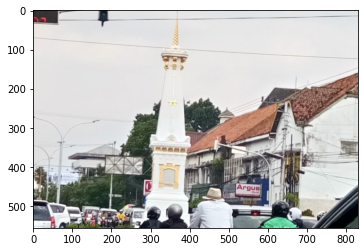

<start> suasana tugu jogja di sore hari <end>
(556, 830, 3)
[[[ 49  45  44]
  [ 48  44  43]
  [ 48  44  43]
  ...
  [224 229 232]
  [224 229 232]
  [224 229 232]]

 [[ 49  45  44]
  [ 49  45  44]
  [ 50  46  45]
  ...
  [224 229 232]
  [224 229 232]
  [224 229 232]]

 [[ 49  45  44]
  [ 50  46  45]
  [ 51  47  46]
  ...
  [224 229 232]
  [223 228 231]
  [224 229 232]]

 ...

 [[248 255 255]
  [247 255 255]
  [246 254 255]
  ...
  [ 58  78  69]
  [ 57  77  68]
  [ 56  76  67]]

 [[245 253 255]
  [245 253 255]
  [244 252 254]
  ...
  [ 55  75  66]
  [ 57  77  68]
  [ 58  78  69]]

 [[235 243 245]
  [235 243 245]
  [235 243 245]
  ...
  [ 56  76  67]
  [ 59  79  70]
  [ 61  81  72]]]


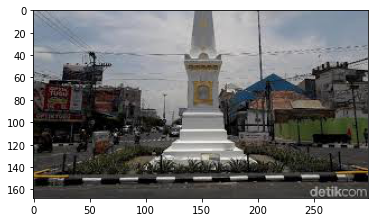

<start> sore yang cerah di tugu jogja <end>
(168, 299, 3)
[[[159 163 172]
  [152 156 165]
  [138 142 151]
  ...
  [126 141 162]
  [126 141 162]
  [126 141 162]]

 [[153 157 166]
  [168 172 181]
  [149 153 162]
  ...
  [126 141 162]
  [126 141 162]
  [126 141 162]]

 [[146 150 161]
  [150 154 165]
  [174 178 189]
  ...
  [126 141 162]
  [126 141 162]
  [126 141 162]]

 ...

 [[ 53  51  52]
  [ 53  51  52]
  [ 54  52  53]
  ...
  [ 91  90  88]
  [126 125 123]
  [ 47  46  44]]

 [[ 55  53  54]
  [ 55  53  54]
  [ 55  53  54]
  ...
  [ 71  70  68]
  [ 84  83  81]
  [ 54  53  51]]

 [[ 60  58  59]
  [ 60  58  59]
  [ 60  58  59]
  ...
  [ 59  58  56]
  [ 57  56  54]
  [ 63  62  60]]]


In [15]:
%pylab inline
import matplotlib.image as mpimg
img=mpimg.imread(img_name_vector[220])
imgplot = plt.imshow(img)
plt.show()

print(train_captions[220])
print(img.shape)
print(img)

img=mpimg.imread(img_name_vector[370])
imgplot = plt.imshow(img)
plt.show()

print(train_captions[370])
print(img.shape)
print(img)

In [16]:
len(train_captions), len(all_captions)

(480, 502)

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [ ]:
# def load_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (299, 299))
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
#     return img, image_path

In [ ]:
# def load_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (224, 224))
#     img = tf.keras.applications.vgg16.preprocess_input(img)
#     return img, image_path

In [17]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, image_path

## Initialize efficientNet and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```7, 7, 1280```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.

#### help(tf.keras.Model)

`Model` groups layers into an object with training and inference features.
There are two ways to instantiate a `Model`:

1. With the "functional API", where you start from `Input`,
you chain layer calls to specify the model's forward pass,
and finally you create your model from inputs and outputs:

### it's use this form
```python
import tensorflow as tf

inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
# image_model = tf.keras.applications.InceptionV3(include_top=False,
#                                                 weights='imagenet')
# # tf.keras.applications.InceptionV3(weights='imagenet').summary()
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
# # image_features_extract_model # image features extractor

# image_features_extract_model.summary()

In [ ]:
# image_model = tf.keras.applications.VGG16(include_top=False,
#                                                 weights='imagenet')
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
# image_features_extract_model.summary()

# tf.keras.applications.VGG16(weights='imagenet').summary()



In [18]:
image_model = tf.keras.applications.EfficientNetB0(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_______________________________________________________________________________________

## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [ ]:
# !pip install tqdm

In [19]:
from tqdm import tqdm

In [20]:
# Get unique images
encode_train = sorted(set(img_name_vector))

In [21]:
len(encode_train) # 

480

In [22]:
encode_train[:5]

['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/02jsutdihcmo58exvz7q.jpeg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/04z6v1thy3xomadl5s7i.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/07ei89fazvcts1rdnuhb.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/0boltxze17pvqajg4ink.jpeg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/0dkmsct9n2f63raxqp7v.jpg']

In [23]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

In [24]:
image_dataset

<TensorSliceDataset shapes: (), types: tf.string>

In [25]:
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16) # map functional programming


In [26]:
image_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>

In [27]:
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img) # image features extractor model
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path): # bf : batch feature , p : path
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
# - `store the resulting vector` `in a dictionary` (image_name --> feature_vector).
# - you pickle the dictionary and save it to disk.

100%|██████████| 30/30 [00:02<00:00, 10.55it/s]


## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [28]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [29]:
# Choose the top 5000 words from the vocabulary
top_k = 200
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [30]:
train_seqs[:5]

[[2, 17, 10, 87, 88, 89, 25, 26, 7, 3],
 [2, 51, 52, 7, 53, 54, 13, 55, 13, 3],
 [2, 11, 10, 43, 4, 5, 24, 3],
 [2, 60, 61, 29, 29, 32, 4, 5, 18, 3],
 [2, 14, 44, 36, 10, 45, 22, 46, 47, 3]]

In [31]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [32]:
tokenizer.index_word[0]

'<pad>'

In [33]:
# print(tokenizer.word_index.items()[:5])
for i, (k,v) in enumerate(tokenizer.word_index.items()):
  print(i,k,v)
  if i == 10:
    break
# print(tokenizer.index_word.items()[:5])
print("-"*10)
for i, (k,v) in enumerate(tokenizer.index_word.items()):
  print(i,k,v)
  if i == 10:
    break

0 <unk> 1
1 <start> 2
2 <end> 3
3 di 4
4 tugu 5
5 jeep 6
6 gunung 7
7 wisata 8
8 malioboro 9
9 yang 10
10 sore 11
----------
0 1 <unk>
1 2 <start>
2 3 <end>
3 4 di
4 5 tugu
5 6 jeep
6 7 gunung
7 8 wisata
8 9 malioboro
9 10 yang
10 11 sore


In [34]:
len(tokenizer.word_index.items())

102

In [35]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [36]:
train_seqs[:5]

[[2, 17, 10, 87, 88, 89, 25, 26, 7, 3],
 [2, 51, 52, 7, 53, 54, 13, 55, 13, 3],
 [2, 11, 10, 43, 4, 5, 24, 3],
 [2, 60, 61, 29, 29, 32, 4, 5, 18, 3],
 [2, 14, 44, 36, 10, 45, 22, 46, 47, 3]]

In [37]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [38]:
cap_vector.shape

(480, 13)

In [39]:
cap_vector[:5]

array([[ 2, 17, 10, 87, 88, 89, 25, 26,  7,  3,  0,  0,  0],
       [ 2, 51, 52,  7, 53, 54, 13, 55, 13,  3,  0,  0,  0],
       [ 2, 11, 10, 43,  4,  5, 24,  3,  0,  0,  0,  0,  0],
       [ 2, 60, 61, 29, 29, 32,  4,  5, 18,  3,  0,  0,  0],
       [ 2, 14, 44, 36, 10, 45, 22, 46, 47,  3,  0,  0,  0]], dtype=int32)

In [40]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [41]:
max_length

13

## Split the data into training and testing

In [42]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [43]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(384, 384, 96, 96)

In [44]:
img_name_train[:5]

['/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/whatsapp_image_2019-06-18_at_21.32.11.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/caozxvjw18reuq2h09tp.png',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/eod0f8y6bntahxzlw2uv.jpg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/9nlpyqhv5mc2j743se8r.jpeg',
 '/home/yurio/mainan_yurio/img_cap_to_icitda/img_caption_dl_textAnalytic/dataset_efficientNet/Jalan-Malioboro-1280x720.jpg']

In [45]:
cap_train[:5]

array([[ 2, 17, 75,  9, 76, 77, 78, 15,  3,  0,  0,  0,  0],
       [ 2, 37,  4, 28, 23,  6, 38,  3,  0,  0,  0,  0,  0],
       [ 2, 37,  4, 28, 23,  6, 38,  3,  0,  0,  0,  0,  0],
       [ 2,  6, 27, 16, 96,  4,  8, 21,  3,  0,  0,  0,  0],
       [ 2, 17, 75,  9, 76, 77, 78, 15,  3,  0,  0,  0,  0]], dtype=int32)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [46]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE  # 384 / 64

In [47]:
num_steps

6

In [48]:
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 1280
attention_features_shape = 49

In [49]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [50]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [51]:
dataset

<TensorSliceDataset shapes: ((), (13,)), types: (tf.string, tf.int32)>

In [52]:
# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [53]:
dataset

<ParallelMapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [54]:
# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [55]:
dataset

<BatchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [56]:
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [57]:
dataset

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [58]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # vector_size 512 + vector_size 512

    # attention_weights shape == (batch_size, 64, 1) # from 512 --> 1 fc
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    print("attention_weights: ",attention_weights)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features # dot_prod feature x attention
    context_vector = tf.reduce_sum(context_vector, axis=1) # vector sum

    return context_vector, attention_weights

In [59]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [60]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [61]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [62]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [63]:
checkpoint_path = PATH + "/checkpoints/efficientNet"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [64]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [65]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [66]:
@tf.function
def train_step(img_tensor, target): # input from img tensor, n target word captions
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) # decide input
  
  print("target.shape[0]: ", target.shape[0])
  print("dec_input: ", dec_input)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)  # 64 x 256
      print("target.shape[1]: ", target.shape[1])

      for i in range(1, target.shape[1]): # loop over the target
          # passing the features through the decoder
          # overwrite hidden from attention
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          print(i)

          loss += loss_function(target[:, i], predictions)
          print("target[:, i]: ", target[:, i])

          # using teacher forcing # overwrite new decide_input
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [67]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

target.shape[0]:  64
dec_input:  Tensor("ExpandDims:0", shape=(64, 1), dtype=int32)
target.shape[1]:  13
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_1:0", shape=(64, 49, 1), dtype=float32)
1
target[:, i]:  Tensor("strided_slice_1:0", shape=(64,), dtype=int32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_3:0", shape=(64, 49, 1), dtype=float32)
2
target[:, i]:  Tensor("strided_slice_4:0", shape=(64,), dtype=int32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_5:0", shape=(64, 49, 1), dtype=float32)
3
target[:, i]:  Tensor("strided_slice_7:0", shape=(64,), dtype=int32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_7:0", shape=(64, 49, 1), dtype=float32)
4
target[:, i]:  Tensor("strided_slice_10:0", shape=(64,), dtype=int32)
attention_weights:  Tensor("rnn__decoder/bahdanau_attention/transpose_9:0", shape=(64, 49, 1), dtype=float32)
5
target[:, i]:  Tensor("strided_slice_13:0", shape=(64,), d

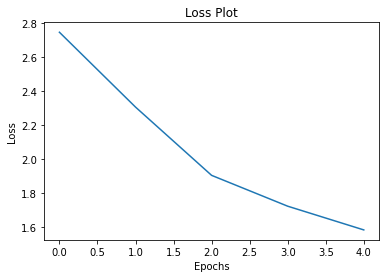

In [68]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [69]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [70]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

attention_weights:  tf.Tensor(
[[[4.27542545e-04]
  [4.57921051e-05]
  [2.32050138e-06]
  [1.26095338e-05]
  [1.69759624e-05]
  [3.79646022e-04]
  [4.81538428e-03]
  [1.17807556e-02]
  [2.33338033e-05]
  [1.69250088e-05]
  [1.77918264e-05]
  [2.81817833e-04]
  [6.22179545e-03]
  [5.39709032e-02]
  [1.94146521e-02]
  [8.84483052e-06]
  [1.84576173e-04]
  [1.45758968e-04]
  [6.75920382e-05]
  [2.95797072e-04]
  [1.15150283e-03]
  [6.49012029e-02]
  [8.76658942e-06]
  [2.19846552e-04]
  [1.04285090e-03]
  [4.81009437e-03]
  [5.87879959e-03]
  [1.82578166e-03]
  [7.71488296e-03]
  [3.33895674e-04]
  [1.25033548e-03]
  [4.07388341e-03]
  [5.75685780e-03]
  [6.68758387e-03]
  [7.60314520e-03]
  [4.34632087e-03]
  [1.38591170e-01]
  [1.68261141e-01]
  [2.02444382e-02]
  [4.26736777e-04]
  [9.06367262e-04]
  [1.18830976e-04]
  [1.89552386e-03]
  [3.31972510e-01]
  [1.19409166e-01]
  [2.24307552e-03]
  [1.02756603e-04]
  [7.63293137e-05]
  [1.53947367e-05]]], shape=(1, 49, 1), dtype=float32)
at

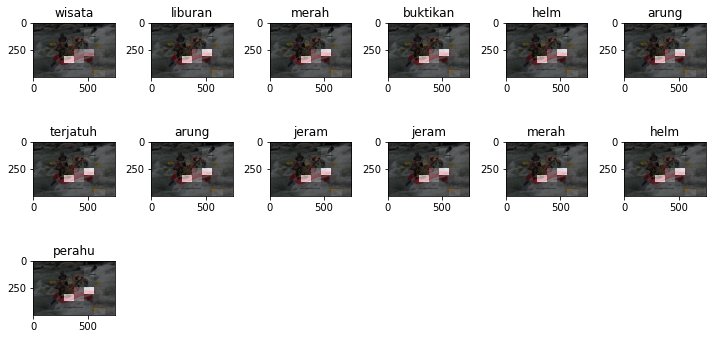

In [71]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


In [ ]:
image_path = '/content/drive/My Drive/img_caption/data_test/IC5.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
image_path = '/content/drive/My Drive/img_caption/data_test/IC4.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
image_path = '/content/drive/My Drive/img_caption/data_test/IC3.JPG'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
image_path = '/content/drive/My Drive/img_caption/data_test/IC2.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
image_path = '/content/drive/My Drive/img_caption/data_test/IC1.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.